# 03 – Threshold Tuning (Validation Set)
Sweep thresholds for precision/recall/F1 to pick an operating point.

Best F1 at threshold 0.25: precision=0.955, recall=0.955, f1=0.955


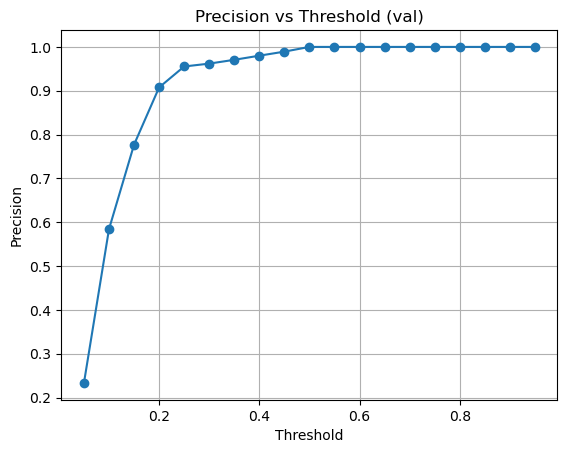

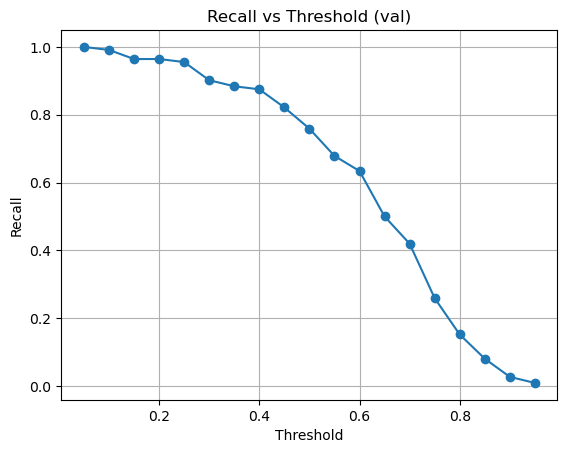

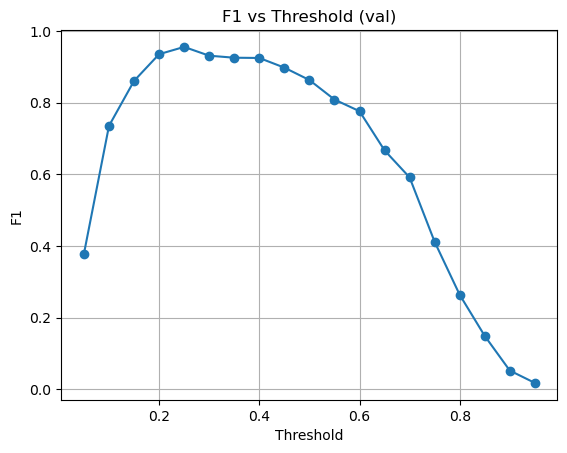

In [3]:
import os, numpy as np, pandas as pd, joblib
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
data_path = '../data/raw/SMSSpamCollection'
model_dir = '../models/latest'
def load_dataset(path):
    try:
        df = pd.read_csv(path, sep='\t', header=None, names=['label','text'], encoding='utf-8')
    except Exception:
        tmp = pd.read_csv(path, encoding='utf-8', engine='python')
        cols = {c.lower(): c for c in tmp.columns}
        label_col = next((cols[c] for c in ['label','class','target','v1'] if c in cols), None)
        text_col  = next((cols[c] for c in ['text','message','sms','v2'] if c in cols), None)
        df = tmp[[label_col, text_col]].rename(columns={label_col:'label', text_col:'text'})
    df = df.dropna(subset=['label','text']).copy()
    df['label'] = (df['label'].astype(str).str.strip().str.lower()
                   .map({'ham':0,'spam':1,'0':0,'1':1}).fillna(df['label']))
    if df['label'].dtype == 'O':
        df['label'] = pd.factorize(df['label'])[0]
    df['text'] = df['text'].astype(str)
    return df[['text','label']]
df = load_dataset(data_path)
X, y = df['text'].values, df['label'].values
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.15, random_state=42, stratify=y)
val_rel = 0.15 / (1.0 - 0.15)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=val_rel, random_state=42, stratify=y_trainval)
pipe = joblib.load(os.path.join(model_dir, 'model.joblib'))
y_prob = pipe.predict_proba(X_val)[:,1]
thresholds = np.linspace(0.05, 0.95, 19)
precisions, recalls, f1s = [], [], []
for t in thresholds:
    y_pred = (y_prob >= t).astype(int)
    precisions.append(precision_score(y_val, y_pred))
    recalls.append(recall_score(y_val, y_pred))
    f1s.append(f1_score(y_val, y_pred))
best_idx = int(np.nanargmax(f1s))
best_t = float(thresholds[best_idx])
best_p, best_r, best_f1 = precisions[best_idx], recalls[best_idx], f1s[best_idx]
print(f'Best F1 at threshold {best_t:.2f}: precision={best_p:.3f}, recall={best_r:.3f}, f1={best_f1:.3f}')
plt.figure(); plt.plot(thresholds, precisions, marker='o'); plt.title('Precision vs Threshold (val)'); plt.xlabel('Threshold'); plt.ylabel('Precision'); plt.grid(True); plt.savefig('../reports/figures/precision_vs_threshold_val.png', dpi=160, bbox_inches='tight'); plt.show()
plt.figure(); plt.plot(thresholds, recalls, marker='o');   plt.title('Recall vs Threshold (val)');    plt.xlabel('Threshold'); plt.ylabel('Recall');    plt.grid(True); plt.savefig('../reports/figures/recall_vs_threshold_val.png', dpi=160, bbox_inches='tight'); plt.show()
plt.figure(); plt.plot(thresholds, f1s, marker='o');       plt.title('F1 vs Threshold (val)');        plt.xlabel('Threshold'); plt.ylabel('F1');        plt.grid(True); plt.savefig('../reports/figures/f1_vs_threshold_val.png', dpi=160, bbox_inches='tight'); plt.show()
